## 6.5 机器学习实例
	这里以葡萄酒（wine）数据集为例，因数据集不大，可以直接从网上下载。
葡萄酒数据集中的数据包括三种酒的13种不同成分的数量。文件中，每行代表一种酒的样本，共有178个样本；一共有14列，其中，第一个属性是类标识符，分别是1/2/3来表示，代表葡萄酒的三个分类。后面的13列为每个样本的对应属性的样本值。剩余的13个属性是，酒精、苹果酸、灰、灰分的碱度、镁、总酚、黄酮类化合物、非黄烷类酚类、原花色素、颜色强度、色调、稀释葡萄酒的OD280/OD315、脯氨酸。其中第1类有59个样本，第2类有71个样本，第3类有48个样本。 具体属性描述如表6-3所示。


|表6-3 葡萄酒数据集属性|
|----------------------|

|英文字段	|中文字段|
|:-----------------------------|:---------------------------|
Class label                     	|类别|
Alcohol                         	|酒精|
Malic acid                      	|苹果酸|
Ash                             	|灰|
Alcalinity of ash               	|灰的碱度|
Magnesium                       	|镁|
Total phenols                   	|总酚|
Flavanoids                      	|类黄酮|
Nonflavanoid phenols            	|非类黄酮酚|
Proanthocyanins                 	|原花青素|
Color intensity                 	|色彩强度|
Hue                             	|色调|
OD280/OD315 of diluted wines    	 |稀释酒的OD280 / OD315|
Proline                         	| 脯氨酸|

1）从网上下载数据。

In [1]:
import numpy as np
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['类别', '酒精', '苹果酸', '灰', 
'灰的碱度', '镁', '总酚', 
'类黄酮', '非类黄酮酚', '原花青素', 
'色彩强度', '色调', '稀释酒的OD280 / OD315', '脯氨酸']

#查看共有哪几种类别
print('类别', np.unique(df_wine['类别']))
#查看数据集前5行
df_wine.head()

类别 [1 2 3]


,类别,酒精,苹果酸,灰,灰的碱度,镁,总酚,类黄酮,非类黄酮酚,原花青素,色彩强度,色调,稀释酒的OD280 / OD315,脯氨酸
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


2）对数据进行标准化处理。

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

3）使用逻辑回归进行训练。

In [4]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.1,solver='liblinear')
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.9838709677419355
Test accuracy: 0.9814814814814815


说明准确率还不错。  
4）可视化各特征的权重系统。

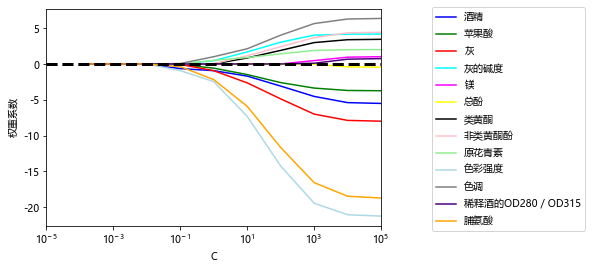

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False 

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
         'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear',random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column+1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('权重系数')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

 图6-22 各特征随着惩罚系数c变化的情况  
5）查看选择的特征数量与模型的准确率的关系。先来定义数据预处理函数。

In [6]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

可视化特征数与准确率之间的关系。

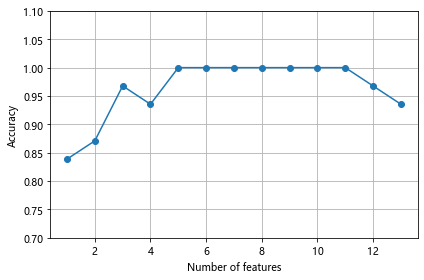

In [7]:
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=2)

# 选择特征
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 可视化特征子集的性能
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

图6-23 特征数与准确率之间的关系  
6）可视化各特征对模型的贡献率。使用随机森林算法，计算特征对模型的贡献。

 1) 酒精                             0.182483
 2) 苹果酸                            0.158610
 3) 灰                              0.150948
 4) 灰的碱度                           0.131987
 5) 镁                              0.106589
 6) 总酚                             0.078243
 7) 类黄酮                            0.060718
 8) 非类黄酮酚                          0.032033
 9) 原花青素                           0.025400
10) 色彩强度                           0.022351
11) 色调                             0.022078
12) 稀释酒的OD280 / OD315              0.014645
13) 脯氨酸                            0.013916


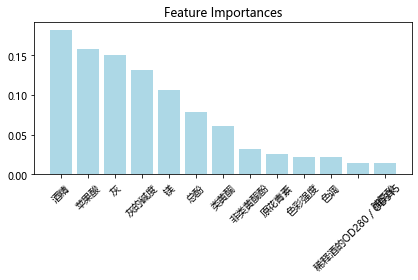

In [8]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[f], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels, rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('./figures/random_forest.png', dpi=300)
plt.show()

图6-24 各特征的贡献率  
    说明酒精这个特征贡献最大，其次是苹果酸、灰等特征。